https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/hugging_face_poisoning.ipynb

## Poisoning Threats of Hugging Face Models

On this notebook is going to be applied the dirty label backdoor attack (DLBD) on the Imagenette dataset and fune tuning a pre-trained Data-efficient Image Transformer (DeiT).


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import transformers

from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import insert_image
from art.defences.preprocessor import Mixup
from art.defences.trainer import DPInstaHideTrainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])
train_dataset = torchvision.datasets.ImageFolder(root="imagewang-320/train", transform=transform)
train_dataset

Dataset ImageFolder
    Number of datapoints: 14669
    Root location: imagewang-320/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [6]:
labels = np.asarray(train_dataset.targets)
classes = np.unique(labels)
samples_per_class = 100

x_subset = []
y_subset = []

for c in classes:
    indices = np.where(labels == c)[0][:samples_per_class]
    for i in indices:
        x_subset.append(train_dataset[i][0])
        y_subset.append(train_dataset[i][1])

x_subset = np.stack(x_subset)
y_subset = np.asarray(y_subset)

print(f'x_subset:', x_subset.dtype, x_subset.shape)
print(f'y_subset:', y_subset.dtype, y_subset.shape)

x_subset: float32 (1975, 3, 224, 224)
y_subset: int32 (1975,)


In [10]:
label_names = [
    'fish',
    'dog',
    'cassette player',
    'chainsaw',
    'church',
    'french horn',
    'garbage truck',
    'gas pump',
    'golf ball',
    'parachutte',
]

In [11]:
# Create state_dicts directory for saving models

if not os.path.isdir('./state_dicts'):
    os.mkdir('./state_dicts')

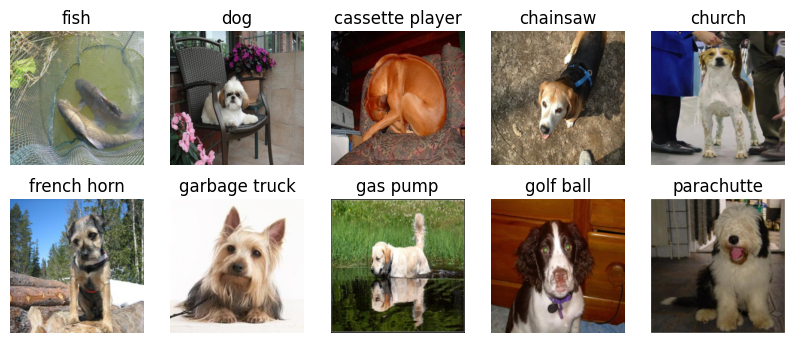

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(0, 5):
    ax[0, i].imshow(np.transpose(x_subset[i * 100], (1, 2, 0)))
    ax[0, i].set_title(label_names[y_subset[i * 100]])
    ax[0, i].axis('off')
    ax[1, i].imshow(np.transpose(x_subset[i * 100 + 500], (1, 2, 0)))
    ax[1, i].set_title(label_names[y_subset[i * 100 + 500]])
    ax[1, i].axis('off')

plt.show()

## Defense

It is going to implement DP-InstaHide poisoning defense, a method that provides differential privacy guarantee 